### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300"> Notebook At a Glance</p>
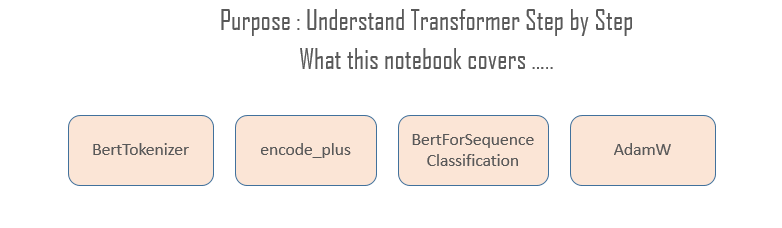

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes : BERT</font></h3>

* BERT (Bidirectional Encoder Representations from Transformers)is a pre-trained deep learning model developed by Google for natural language processing (NLP) tasks

* BertTokenizer class is used to convert input text into a sequence of tokens that can be fed into a BERT-based model for further processing.

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes : TensorDataset</font></h3>

* can be used to create a dataset from a set of tensors.

* takes one or more tensors as input.
    
* creates a dataset where each sample is a tuple of corresponding elements from the input tensors.

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes : DataLoader</font></h3>

* loads data from a dataset in batches. 

* takes a dataset object as input.
    
* provides an iterator that yields batches of data.

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes : RandomSampler</font></h3>

* randomly samples elements from a dataset. 

* It is typically used with the DataLoader class to randomly sample batches of data.
    

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes : SequentialSampler</font></h3>

* samples elements from a dataset in sequential order. 

* It is typically used with the DataLoader class to iterate over the entire dataset in order.


#### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300"> Import libraries</p>

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score

from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from transformers import BertTokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import random
import time
import datetime

from tensorflow.keras.preprocessing.sequence import pad_sequences

from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup

#### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">  Data load and data preprocessing</p>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* Combind fake and real news by using concat methods.

* Confusion of indices is resolved using rest_index method.
    
* Missing value is checked using isnull method.

    

In [2]:
df_fake = pd.read_csv("/kaggle/input/true-fake-news-dataset/Fake_True/Fake.csv")
df_real = pd.read_csv("/kaggle/input/true-fake-news-dataset/Fake_True/True.csv")

df_fake["category"] = 1
df_real["category"] = 0

df = pd.concat([df_fake, df_real])

In [3]:
df = df.reset_index(drop=True)

In [4]:
df.isnull().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [5]:
df.isnull().sum().sum()

0

#### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">  Loading BertTokenizer</p>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* Pre-trained BERT tokenizer is loaded from the Hugging Face Transformers library using from_pretrained method.

* bert-base-uncased tokenizer, a BERT model, has been pre-trained on a large corpus of uncased English text.
    
* Since bert-base-uncased model was trained on uncased text, all input text is lowercased setting do_lower_case = True, so that any not lowercased input text  will be treated as out-of-vocabulary (OOV) tokens by the tokenizer

In [7]:
#importing the Bert and loading BertTokenizer
print("Loading BertTokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BertTokenizer...


In [8]:
df_update = df.drop('category', axis=1)
y = df.category

In [9]:
y.value_counts()

1    23481
0    21417
Name: category, dtype: int64

In [10]:
df_train, df_test, y_train, y_test = train_test_split(df_update, y, random_state=42, test_size=0.20, stratify = y)

In [11]:
y_train

36928    0
30548    0
37469    0
9447     1
24880    0
        ..
34145    0
34233    0
26021    0
39705    0
1255     1
Name: category, Length: 35918, dtype: int64

In [12]:
df_train['final'] = df_train['title']

In [13]:
statements = df_train['final']

In [14]:
bert_input_ids = []
bert_attention_masks = []
roberta_input_ids = []
roberta_attention_masks = []
sentence_ids = []
counter = 0

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes : encode_plus</font></h3>

* It is used to encode a sentence or a sequence of sentences into BERT input features

* Special [CLS] and [SEP] tokens are added to the input sentence using add_special_tokens=True argument

* maximum length of the input sentence after padding and truncation is specified to 120 using max_length=120 argument
    
* input sentence is padded to a length of max_length using the [PAD] token by setting pad_to_max_length=True argument
    
* attention mask is constructed for the input sentence by setting return_attention_mask=True argument
    
* BERT input features are returned as PyTorch tensor by setting return_tensors='pt' argument

In [15]:
# For every sentence ...
for sent in statements:
    bert_encoded_dict = tokenizer.encode_plus(
                        sent, #Sentence to encode
                        add_special_tokens = True, # Add `[CLS]` and `[SEP]`
                        max_length = 120, # Pad and Truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True, # Construct Attention Masks
                        return_tensors = 'pt' # Return PyTorch Tensor
                        )
    bert_input_ids.append(bert_encoded_dict['input_ids'])
    bert_attention_masks.append(bert_encoded_dict['attention_mask'])
    sentence_ids.append(counter)
    counter = counter + 1

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* BERT model requires the input features and attention masks to be of the same shape, so BERT input features and attention masks are concatenated along the 0th dimension, creating a single tensor for each


In [16]:
bert_input_ids = torch.cat(bert_input_ids, dim = 0)
bert_attention_masks = torch.cat(bert_attention_masks, dim = 0)
labels = torch.tensor(y_train.values)
sentence_ids = torch.tensor(sentence_ids)

In [17]:
print(bert_input_ids)
print("\n")
print(bert_attention_masks)
print("\n")
print(sentence_ids)
print("\n")

tensor([[  101,  2605, 18675,  ...,     0,     0,     0],
        [  101,  8398,  7906,  ...,     0,     0,     0],
        [  101,  3163,  1005,  ...,     0,     0,     0],
        ...,
        [  101,  4254,  1997,  ...,     0,     0,     0],
        [  101,  1057,  1012,  ...,     0,     0,     0],
        [  101,  8398,  6017,  ...,     0,     0,     0]])


tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


tensor([    0,     1,     2,  ..., 35915, 35916, 35917])




In [18]:
print(bert_input_ids.shape)
print(bert_attention_masks.shape)
print(labels.shape)


torch.Size([35918, 120])
torch.Size([35918, 120])
torch.Size([35918])


In [19]:
bert_dataset = TensorDataset(bert_input_ids, bert_attention_masks, labels)

In [20]:
print(bert_dataset)

In [21]:
len(bert_dataset)

35918

In [22]:
train_size = int(0.8 * len(bert_dataset))
val_size = len(bert_dataset) - train_size

# Dvide the dataset by randomly selecting samples
bert_train_dataset, bert_val_dataset = torch.utils.data.random_split(bert_dataset, [train_size, val_size])

In [23]:
val_size

7184

In [24]:
batch_size = 7

bert_train_dataloader = DataLoader(
                        bert_train_dataset, # The training samples
                        sampler = RandomSampler(bert_train_dataset), # Select batches randomly
                        batch_size = batch_size # Trains with this batch size
                    )

# For validation the order doesn't matter, so we'll just read them sequentially
bert_validation_dataloader = DataLoader(
                        bert_val_dataset, # The validation samples
                        sampler = SequentialSampler(bert_val_dataset), # Pull out batches sequentially
                        batch_size = batch_size # Trains with this batch size
                    )

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes : BertForSequenceClassification</font></h3>

* It has been fine-tuned for sequence classification tasks.

* BertForSequenceClassification model is created from the pre-trained bert-base-uncased model. This is a 12-layer BERT model with an uncased vocabulary. 

* The num_labels parameter is set to 2, indicating that the model will be used for binary classification
    
* output_attentions and output_hidden_states are set to false, indicates, the model will not return the attention weights and the hidden states

In [25]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top

model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", 
        num_labels = 2,                 
        output_attentions = False, 
        output_hidden_states = False, 
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes : AdamW </font></h3>

* It is a variant of the Adam optimizer.

* It is a popular choice for fine-tuning BERT models, includes weight decay as a regularization technique to prevent overfitting. 

In [26]:
bert_optimizer = AdamW(model.parameters(),
                      lr =  2e-5, # args.learning_rate - default is 5e-5
                      eps = 1e-8  # args.adam_epsilon  - default is 1e-8
                      )

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes : get_linear_schedule_with_warmup() </font></h3>

* It creates a linear schedule with a warmup period, a common strategy for fine-tuning BERT models.

* During the warmup period, the learning rate is gradually increased from a small value to the initial learning rate specified by the user. This helps to prevent the model from getting stuck in local minima during the early stages of training.
    
* After the warmup period, the learning rate is decreased linearly until it reaches a very small value. This helps to prevent the model from overfitting to the training data.

In [27]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We choose to run for 1, due to lack of GPU

epochs = 1

# Total no of training step is [number of batches] × [number of epochs]
# Note that this is not the same as the number of training samples

total_steps = len(bert_train_dataloader) * epochs

# Create the learning rate scheduler
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [28]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [29]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes : </font></h3>

* The logits tensor is detached from the computation graph and converted to a regular NumPy array using The detach() method. 
    
* The detach() method is used because we don't want to backpropagate through the logits when computing gradients and updating model weights.
    
* During each evaluation step, the loss is computed for the batch and added to the eval_loss variable using the item() method, which retrieves the scalar value of the loss tensor.

#### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300"> Training the Model </p>

In [30]:


# Set the seed value all over the place to make this reproducible
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

# Store the average loss after each epoch so we can plot them
loss_values = []
val_loss = []
# For each epoch ...
for epoch_i in range(0, epochs):
    # ===============================
    #            Training
    # ===============================
    # Perform one full pass over the training set
    
    print("")
    print('=======Epoch {:} / {:}======='.format(epoch_i + 1, epochs))
    print('Training...')
    
    # Measure how long the training epoch takes
    t0 = time.time()
    
    # Reset the total loss for this epoch
    total_loss = 0
    

    model.train()
    
    # For each batch of training data...
    for step, batch in enumerate(bert_train_dataloader):
        
        # Progress Update every 100 batches
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes
            elapsed = format_time(time.time() - t0)
            
            # Report Progress
            print(' Batch {:>5,} of {:5,}.  Elapsed: {:}.'.format(step, len(bert_train_dataloader), elapsed))
            
        # Unpack this training batch from our dataloader
        # As we unpack the batch, we'll copy each tensor 
        # `batch` contains three pytorch tensors
        # [0] : input ids
        # [1] : attention masks
        # [2] : labels
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]
        
        # Always clear any previously calculated gradients before performing a backward pass
        # PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs"
        
        model.zero_grad()
        
        # Perform a forward pass (evaluate the model on this training batch)
        # In PyTorch, calling `model` will in turn call the model's "forward" function and pass down the arguments.
        # The "forward" function is doccumented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        
        result = model(b_input_ids,
                      token_type_ids = None,
                      attention_mask = b_input_mask,
                      labels = b_labels,
                      return_dict=True)
        
        loss = result.loss
        
        # Accumulate the training loss over all the batches so that we can calculate the average loss at the end.
        # `loss` is a Tensor containing a single value;
        # the `.item()` function just returns the Python Value from the tensor
        total_loss += loss.item()
        
        # Perform a backward Pass to calculate the gradients
        loss.backward()
        
        # Clip the norm of gradients to 1.0
        # This is to help preventing the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update Parameters and take a step using the computed gradient
        # The optimizer dictate the "update rule" - how the parameters are modified based on their gradients, the learning rate etc.
        bert_optimizer.step()
        
        # Update the learning rate
        bert_scheduler.step()
        
    # Calculate the average loss over the training data 
    avg_train_loss = total_loss / len(bert_train_dataloader)
    
    # Store the loss value for plotting the learning curve
    loss_values.append(avg_train_loss)
    
    print("")
    print("Average Training Loss: {0:.2f}".format(avg_train_loss))
    print("Training Epoch took: {:}".format(format_time(time.time() - t0)))
    
    # ========================================
    #                Validation
    # ========================================
    # After the completion of each training epoch, 
    # measure the performance on our validation dataset
    
    print("")
    print("Running Validation...")
    
    t0 = time.time()
    
    # In evaluation mode -- dropout layers behave differently during evaluation
    model.eval()
    
    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    
    # Evaluate data for one epoch
    for batch in bert_validation_dataloader:
        
        batch = tuple(t for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, 
        # saving memory and speeding up validation
        
        with torch.no_grad():
            # Forward Pass, calculate logit predictions
            # token_type_ids is the same as the "segment ids", 
            # which differentiates sentence 1 and 2 in 2-sentence tasks
            result = model(b_input_ids,
                          token_type_ids = None,
                          attention_mask = b_input_mask,
                          labels = b_labels,
                          return_dict = True)
        # Get the loss and "logits" by the output model. The "logits"
        # are the output values prior to applying an activation function 
        # like the softmax
        
        loss = result.loss
        logits = result.logits
        
        logits = logits.detach().numpy()
        label_ids = b_labels.numpy()
        
        # Calculate the accuracy for this batch of test sentences
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy
        eval_accuracy += tmp_eval_accuracy
        
        # Track the no of batches
        nb_eval_steps += 1
        
        eval_loss += loss.item()
        
    avg_valid_loss = eval_loss / nb_eval_steps
    val_loss.append(avg_valid_loss)
    
    # Report the final accuracy for this validation run
    print("Loss: {0:.2f}".format(eval_loss/len(bert_validation_dataloader)))
    print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("Validation took: {:}".format(format_time(time.time()- t0)))
    
print("")
print("Training Complete!")


=======Epoch 1 / 1=======
Training...
 Batch   100 of 4,105.  Elapsed: 0:08:44.
 Batch   200 of 4,105.  Elapsed: 0:17:18.
 Batch   300 of 4,105.  Elapsed: 0:25:44.
 Batch   400 of 4,105.  Elapsed: 0:34:09.
 Batch   500 of 4,105.  Elapsed: 0:42:35.
 Batch   600 of 4,105.  Elapsed: 0:51:04.
 Batch   700 of 4,105.  Elapsed: 0:59:34.
 Batch   800 of 4,105.  Elapsed: 1:07:59.
 Batch   900 of 4,105.  Elapsed: 1:16:26.
 Batch 1,000 of 4,105.  Elapsed: 1:24:50.
 Batch 1,100 of 4,105.  Elapsed: 1:33:18.
 Batch 1,200 of 4,105.  Elapsed: 1:41:46.
 Batch 1,300 of 4,105.  Elapsed: 1:50:13.
 Batch 1,400 of 4,105.  Elapsed: 1:58:36.
 Batch 1,500 of 4,105.  Elapsed: 2:07:02.
 Batch 1,600 of 4,105.  Elapsed: 2:15:32.
 Batch 1,700 of 4,105.  Elapsed: 2:23:58.
 Batch 1,800 of 4,105.  Elapsed: 2:32:18.
 Batch 1,900 of 4,105.  Elapsed: 2:40:34.
 Batch 2,000 of 4,105.  Elapsed: 2:48:49.
 Batch 2,100 of 4,105.  Elapsed: 2:57:03.
 Batch 2,200 of 4,105.  Elapsed: 3:05:29.
 Batch 2,300 of 4,105.  Elapsed: 3:13

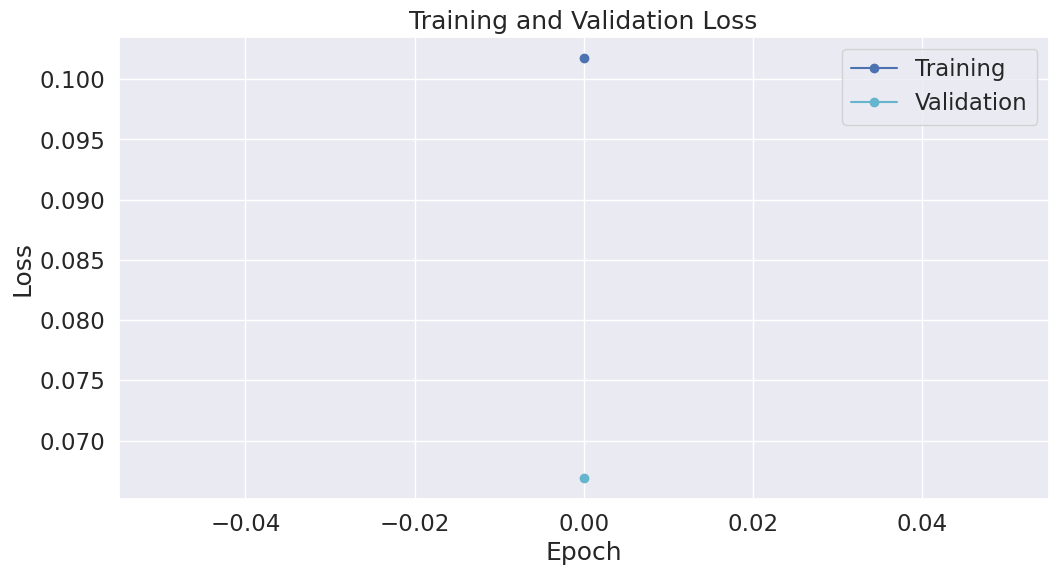

In [31]:
# Use plot styling from seaborn
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)

# Plot the learning curve
plt.plot(loss_values, 'b-o')
plt.plot(val_loss, 'c-o')

# Label the plot
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.gca().legend(("Training", "Validation"))

plt.show()

In [32]:
df_test

,title,text,subject,date
2349,Dem AGs Respond To Trump Rolling Back Clean W...,Amateur president Donald Trump s hostility tow...,News,"March 1, 2017"
28439,Trump to nominate Goldman Sachs' Donovan as de...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"March 15, 2017"
40824,Iraqi forces to regain Kurdish oilfields to re...,BAGHDAD (Reuters) - Iraq will deploy troops to...,worldnews,"October 16, 2017"
38647,Britain agrees to set EU 'Exit Day' in law,LONDON (Reuters) - Britain s government said o...,worldnews,"November 9, 2017"
36,Republican National Committee: Better A Pedop...,"By now, the whole world knows that Alabama Sen...",News,"December 5, 2017"
...,...,...,...,...
3883,Trump Supporter Pulls Gun On Man Because He R...,"Of course, this happened in Florida.After repo...",News,"November 8, 2016"
11860,OUTSTANDING! WATCH Lee Greenwood Sing ‘God Ble...,,politics,"Jan 19, 2017"
18689,STEPHEN COLBERT’S RESPONSE To His Vulgar Remar...,Johnny Carson must be rolling over in his grav...,left-news,"May 4, 2017"
6417,WATCH: North Carolina Governor Wants To Kill ...,"In 2013, conservatives used their 5-4 majority...",News,"May 12, 2016"


In [33]:
df_test.isnull().sum().sum()

0

In [34]:
df_test['final'] = df_test['title']

In [35]:
test_statements = df_test['final']

In [36]:
test_comments = y_test

In [37]:
test_comments.values

array([1, 0, 0, ..., 1, 1, 0])

In [38]:
# Set the required sentence length
MAX_LEN = 128

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0
bert_input_ids = pad_sequences(bert_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 128 values...

Padding token: "[PAD]", ID: 0

Done.


In [39]:
# Tokenize all of the sentences and map the tokens to their word IDs
test_input_ids = []

# For every sentence...
for sent in test_statements:
    # Report Progress
    if ((len(bert_input_ids) % 20000) == 0):
        print('Read {:,} comments.'.format(len(bert_input_ids)))
        
    
    encoded_sent = tokenizer.encode(sent, # Sentence to encode
                                    add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                    max_length = MAX_LEN #Truncate All sentences
                                   )
    
    # Add the encoded sentence to the list
    test_input_ids.append(encoded_sent)
    
print('DONE')
print('')
print('{:>10,} test comments'.format(len(test_input_ids)))

# Also retrieve the labels as a list

# Get the labels from DataFrame and convert booleans to ints


print('{:>10,} positive (contains attack)'.format(np.sum(test_comments)))
print('{:>10,} negative (not an attack)'.format(len(test_comments)- np.sum(test_comments)))

# Pad our input tokens
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
test_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in test_input_ids:
    seq_mask = [float(i>0) for i in seq]
    test_attention_masks.append(seq_mask)
    
# Convert to tensors
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_comments.values)

# Set the batch size
batch_size = 32

# Create the DataLoader
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

DONE

     8,980 test comments
     4,696 positive (contains attack)
     4,284 negative (not an attack)


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* Based on the informations above, we can see there are:
* 8,980 test comments; 4,696 positive and 4,284 negative

#### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300"> Testing the Model</p>

In [40]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking Variables
predictions, true_labels = [], []

# Measure elapsed time
t0 = time.time()

# Predict
for (step, batch) in enumerate(test_dataloader):
    
    batch = tuple(t for t in batch)
    
    # Progress Update every 100 batches
    if step % 100 == 0 and not step == 0:
        # Calculate elased time in minutes
        elapsed = format_time(time.time() - t0)
        
        # Report Progress
        print(' Batch {:>5,} of {:>5,}. Elapsed: {:}'.format(step, len(test_dataloader), elapsed))
        
        # Unpack the inputs from DataLoader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients,
        # saving memory and speeding up prediction
        with torch.no_grad():
            # Forward Pass, calculate logit predictions
            result = model(b_input_ids, 
                          token_type_ids=None,
                          attention_mask=b_input_mask,
                          return_dict=True)
            
        logits = result.logits
        
        logits = logits.detach().numpy()
        label_ids = b_labels.numpy()
        
        # Store Predictions and True Labels
        predictions.append(logits)
        true_labels.append(label_ids)
        
print('    Done.    ')

Predicting labels for 8,980 test sentences...
 Batch   100 of   281. Elapsed: 0:00:00
 Batch   200 of   281. Elapsed: 0:00:06
    Done.    


In [41]:
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

In [42]:
# Use the model output for label 1 as our predictions
p1 = predictions[:, 1]

# Calculate the ROC, AUC
auc = roc_auc_score(true_labels, p1)

print('Test ROC AUC: %3f' %auc)

Test ROC AUC: 1.000000


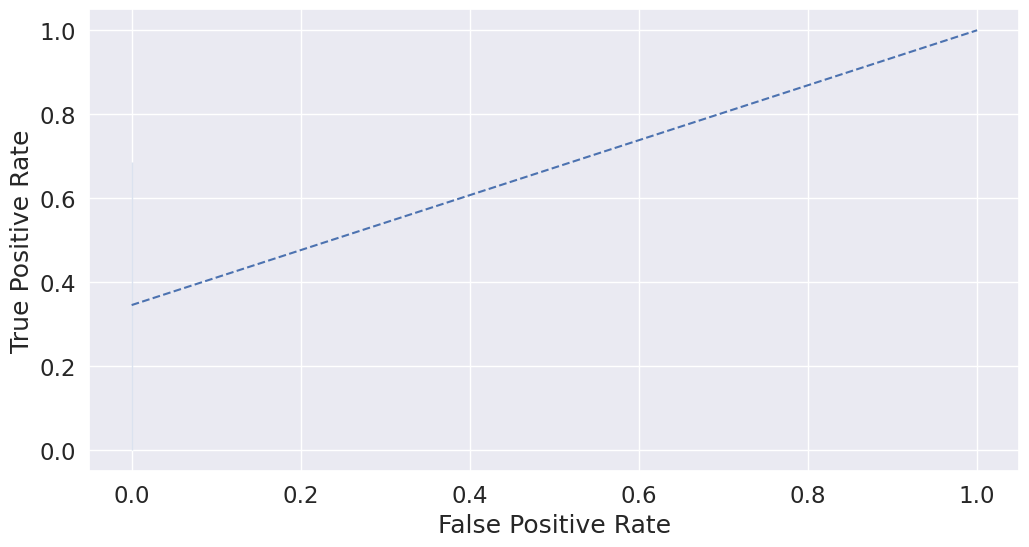

In [43]:
fpr, tpr, _ = metrics.roc_curve(true_labels, p1)
sns.lineplot(x=fpr, y=tpr, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [44]:
predictions = np.argmax(predictions, axis=1).flatten()

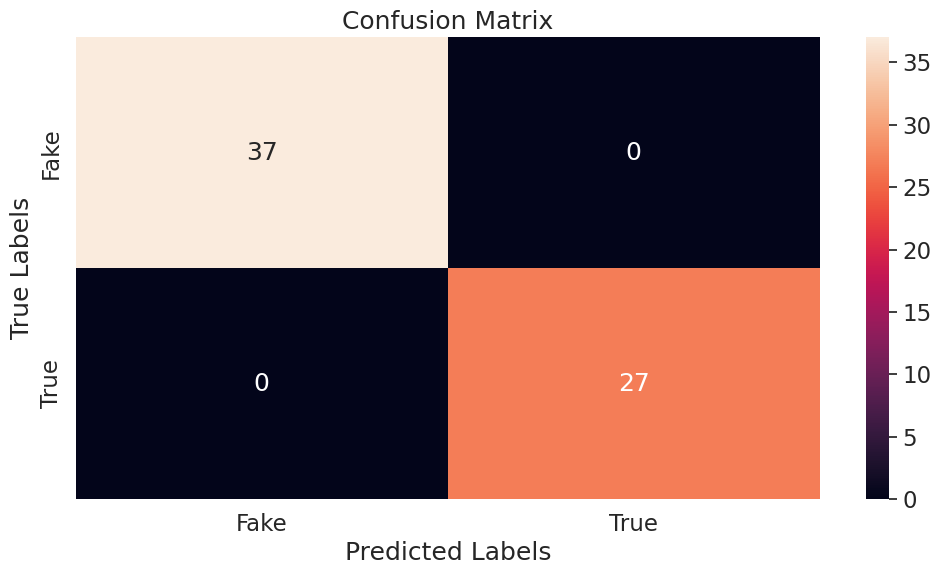

In [45]:
mat = confusion_matrix(true_labels, predictions)
ax = plt.subplot()
sns.heatmap(mat, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Fake', 'True']);ax.yaxis.set_ticklabels(['Fake', 'True']);

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* Based on confusion matrix above, we can see there is no false positive and false negative.
    
* So, model performs pretty well.

In [46]:
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        27

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64



References:
1. https://www.kaggle.com/code/kimtaehun/netflix-disney-content-data-visualization